## ML project 2

### Notes

- train model for each expert
- 0.5 'missing gender' something else than male/ female
- model ohne metadata wie age gender etc, just the coughs
- person coughs --> want to tell wether wet or dry
- dont use other expert information

Features:

- Columns C-BQ: Computed features in the time and frequency domain
- Column BR: The expert that reviewed the cough
- Columns BS-BV: Metadata features provided by users
    - Some values were not provided by users and were set to average values for each feature
- The 'SNR' feature exists for non-segmented coughs but not segmented coughs

MISC:

- Deal with missing metadata appropriately

- Perform exploratory data analysis and feature engineering (ex. examine the effects of normalizing features, recursive feature elimination)

- Make sure that data from a single subject does not end up in both the training and validation groups

Cross validation:

- Compare the success of different classifiers, very carefully performing a fair model comparison (i.e. relying on validation scores using leave-n-subjects-out cross-validation).

Model Comparison:


- Compare classification success on segmented and non-segmented cough recordings (all pre-processing will be done by the lab)
- Tune the model hyperparameters appropriately

- Assess the importance of different features to the classification result by analyzing the weights of the classifier or SHAP values.


In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import IPython.display
import matplotlib.pyplot as plt
import importlib
import src.utils
from src.utils.preprocessing import standardize, dummy_code, oversample, remove_correlated_features
from src.utils.get_data import import_data
from src.utils.model_helpers import roc_w_cross_val, AUC_all_models, homemade_all_models
from src.utils.model_helpers import cross_validation
from src.utils.feature_engineering import RFE_, train_optimal_features_model

In [44]:
# Preprocessing
from imblearn.over_sampling import SMOTE
# ML models
from sklearn.metrics import plot_roc_curve, auc, roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as Lda
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [45]:
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
# dir(src.utils.preprocessing)

In [47]:
DATA_PATH = '../../data'

## Load Data

In [48]:
# Load data
# Labels: # 1 - Wet Cough # 0 - Dry Cough
coarse_data, coarse_labels = import_data(DATA_PATH, segmentation_type = 'coarse', is_user_features=True)
fine_data, fine_labels = import_data(DATA_PATH, segmentation_type = 'fine', is_user_features=True)
no_data, no_labels = import_data(DATA_PATH, segmentation_type = 'no', is_user_features=True)

# For later processing rename the index
no_data.index = no_data.index.rename('subject')
#display(coarse_data.head(2), fine_data.head(2), no_data.head(2))
#display(coarse_labels.head(2), fine_labels.head(2), no_labels.head(2))

In [49]:
# if no preprocessing is desired
X_coarse = coarse_data
X_fine = fine_data
X_no = no_data

## EDA

In [50]:
# Xavi?

## Data Preprocessing

### Normalization

In [51]:
# For case where is_user_features=True
X_coarse = standardize(X_coarse, 0, -3)
X_fine = standardize(X_fine, 0, -3)
X_no = standardize(X_no, 0, -3)

### Inspect Missing Data

### Dummy code categorical features

In [52]:
X_coarse = dummy_code(X_coarse, columns = ['Gender', 'Resp_Condition', 'Symptoms'])
X_fine = dummy_code(X_fine, columns = ['Gender', 'Resp_Condition', 'Symptoms'])
X_no = dummy_code(X_no, columns = ['Gender', 'Resp_Condition', 'Symptoms'])

### Train and Test data

In [53]:
#no_data_X_tr, no_labels_y_tr, no_data_X_te,  no_labels_y_te = train_test_split(X_no, no_labels)
#coarse_data_X_tr, coarse_labels_y_tr, coarse_data_X_te, coarse_labels_y_te = train_test_split(X_coarse, coarse_labels)
#fine_data_X_tr, fine_labels_y_tr, fine_data_X_te, fine_labels_y_te = train_test_split(X_fine, fine_labels)

### Class imbalance

In [54]:
print("Proportion of positive labels:", "\n", np.round(no_labels['Label'].sum() / no_labels['Label'].shape[0],4), 
                                              np.round(coarse_labels['Label'].sum() / coarse_labels['Label'].shape[0],4),
      np.round(fine_labels['Label'].sum() / fine_labels['Label'].shape[0],4))

Proportion of positive labels: 
 0.2592 0.2698 0.2712


#### Has to be applied after splitting train and test set, since it cancels out multilevel indexes

In [55]:
# Do something about it: SMOTE
X_coarse, coarse_labels = oversample(X_coarse, coarse_labels)
X_fine, fine_labels = oversample(X_fine, fine_labels)
X_no, no_labels = oversample(X_no, no_labels)

## Feature Engineering

### Feature Selection

#### Drop correlated features

In [56]:
# Drop features with a Pearson correlation > 0.9 to prevent multicollinearity
X_no = remove_correlated_features(X_no, 0.95)
X_coarse = remove_correlated_features(X_coarse, 0.95)
X_fine = remove_correlated_features(X_fine, 0.95)

### Find interesting features

#### Recursive Feature Elimination

In [57]:
auc_mean, ranks = train_optimal_features_model(X_no, no_labels.Label, LogisticRegression(), start_idx = 1)

KeyboardInterrupt: 

###  Polynomial Feature Expansion

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

NameError: name 'plot' is not defined

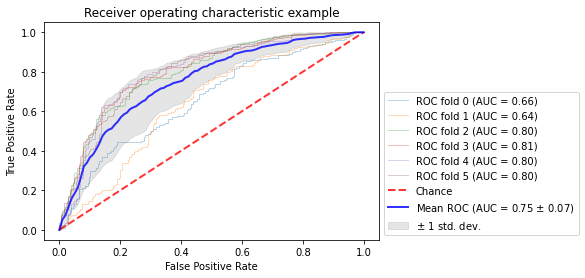

In [59]:
# Inspect effects for log regression
roc_w_cross_val(X_no, no_labels.Label, LogisticRegression())
roc_w_cross_val(X_coarse, coarse_labels.Label, LogisticRegression())
roc_w_cross_val(X_fine, fine_labels.Label, LogisticRegression())

## Model Training

In [ ]:
# Prep: Standardize, Dummy code, SMOTE
coarse_results = AUC_all_models(X_coarse, coarse_labels.Label)
fine_results = AUC_all_models(X_fine, fine_labels.Label)
no_results = AUC_all_models(X_no, no_labels.Label)

#### Inspect results

In [ ]:
coarse_results = coarse_results.rename(columns={'AUC (mean)': "Coarse_AUC"})
fine_results = fine_results.rename(columns={'AUC (mean)': "Fine_AUC"})
no_results = no_results.rename(columns={'AUC (mean)': "No_Seg_AUC"})

In [74]:
# Prep: Standardize, Dummy code, SMOTE
pd.concat([coarse_results, fine_results["Fine_AUC"], no_results["No_Seg_AUC"]], axis=1, sort=False)
# Most promising seem to be RandomForest and GradientBoosting --> Tune their hyperparameters!

,Models,Coarse_AUC,Fine_AUC,No_Seg_AUC
0,LogisticRegression,0.736711,0.697576,0.758064
1,SVM,0.735363,0.696925,0.752737
2,LDA,0.737499,0.697807,0.757440
3,KNN,0.747687,0.768130,0.740972
4,GaussianNB,0.676868,0.616945,0.706647
5,DecisionTree,0.707626,0.715493,0.725002
6,RandomForest,0.837784,0.858616,0.863629
7,GradientBoosting,0.846497,0.856607,0.869600


In [80]:
# Prep: Standardize, Dummy code, SMOTE, drop correlated features
coarse_results_2 = AUC_all_models(X_coarse, coarse_labels.Label)
fine_results_2 = AUC_all_models(X_fine, fine_labels.Label)
no_results_2 = AUC_all_models(X_no, no_labels.Label)

coarse_results_2 = coarse_results.rename(columns={'AUC (mean)': "Coarse_AUC"})
fine_results_2 = fine_results.rename(columns={'AUC (mean)': "Fine_AUC"})
no_results_2 = no_results.rename(columns={'AUC (mean)': "No_Seg_AUC"})

In [1]:
# Results prep 2
pd.concat([coarse_results_2, fine_results_2["Fine_AUC"], no_results_2["No_Seg_AUC"]], axis=1, sort=False)
#-> no better than with correlated features

NameError: name 'pd' is not defined

### Visualize GradientBoost

In [20]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import export_graphviz
import numpy as np


# Classifier
clf = GradientBoostingClassifier(max_depth=3, random_state=0)
clf.fit(X_no, no_labels.Label)


# Get the tree number 42
sub_tree_42 = clf.estimators_[42, 0]

# Visualization. Install graphviz in your system
from pydotplus import graph_from_dot_data
from IPython.display import Image
import pydotplus

dot_data = export_graphviz(
    sub_tree_42,
    out_file=None, filled=True, rounded=True,
    special_characters=True,
    proportion=False, impurity=False, # enable them if you want
)
graph = graph_from_dot_data(dot_data)
#Image(graph.create_png())

In [24]:
#dot_data = sub_tree_42.export_graphviz(clf)
graph = pydotplus.graphviz.graph_from_dot_data(dot_data)
Image(graph.create_png())

InvocationException: GraphViz's executables not found

### Hyperparameter Tuning 

#### Most promising seem to be RandomForest and GradientBoosting 


#### Train optimal features model for RandomForest and GradientBoosting

In [ ]:
# Takes a long time to compute
X_no_GB = get_optimal_features_model(X_no, no_labels.Label, GradientBoostingClassifier(random_state=0), start_idx = 1)

In [ ]:
# Train optimal features model for RandomForest and GradientBoosting
X_no_RF = get_optimal_features_model(X_no, no_labels.Label, RandomForestClassifier(max_depth=7, random_state=0), start_idx = 1)
X_fine_RF = get_optimal_features_model(X_fine, fine_labels.Label, RandomForestClassifier(max_depth=7, random_state=0), start_idx = 1)
X_coarse_RF = get_optimal_features_model(X_coarse, coarse_labels.Label, RandomForestClassifier(max_depth=7, random_state=0), start_idx = 1)

X_no_GB = get_optimal_features_model(X_no, no_labels.Label, GradientBoostingClassifier(random_state=0), start_idx = 1)
X_fine_GB = get_optimal_features_model(X_fine, fine_labels.Label, GradientBoostingClassifier(random_state=0), start_idx = 1)
X_coarse_GB = get_optimal_features_model(X_coarse, coarse_labels.Label, GradientBoostingClassifier(random_state=0), start_idx = 1)

## Models

In [ ]:
# Takes a long time to compute
X_no_GB = get_optimal_features_model(X_no, no_labels.Label, GradientBoostingClassifier(random_state=0), start_idx = 1)

>1 0.785 (0.017)
>2 0.790 (0.021)


In [91]:
# Train optimal features model for RandomForest and GradientBoosting
X_no_RF = get_optimal_features_model(X_no, no_labels.Label, RandomForestClassifier(max_depth=7, random_state=0), start_idx = 1)
X_fine_RF = get_optimal_features_model(X_fine, fine_labels.Label, RandomForestClassifier(max_depth=7, random_state=0), start_idx = 1)
X_coarse_RF = get_optimal_features_model(X_coarse, coarse_labels.Label, RandomForestClassifier(max_depth=7, random_state=0), start_idx = 1)

X_no_GB = get_optimal_features_model(X_no, no_labels.Label, GradientBoostingClassifier(random_state=0), start_idx = 1)
X_fine_GB = get_optimal_features_model(X_fine, fine_labels.Label, GradientBoostingClassifier(random_state=0), start_idx = 1)
X_coarse_GB = get_optimal_features_model(X_coarse, coarse_labels.Label, GradientBoostingClassifier(random_state=0), start_idx = 1)

KeyboardInterrupt: 

## Models

### Logistic regression

In [53]:
roc_w_cross_val(X_no, no_labels.Label, LogisticRegression())

### k Nearest Neighbour

In [ ]:
roc_w_cross_val(no_data_X_tr, no_labels_y_tr, KNeighborsClassifier(n_neighbors=16))

### Gaussian Naive Bayes

In [ ]:
roc_w_cross_val(no_data_X_tr, no_labels_y_tr, GaussianNB())

### Decision Tree

In [ ]:
roc_w_cross_val(no_data_X_tr, no_labels_y_tr, DecisionTreeClassifier(random_state=0))

### RandomForest

In [ ]:
roc_w_cross_val(no_data_X_tr, no_labels_y_tr, RandomForestClassifier(max_depth=7, random_state=0))

### eXtreme Gradient Boosting

In [ ]:
roc_w_cross_val(no_data_X_tr, no_labels_y_tr, GradientBoostingClassifier(random_state=0))